In [1]:
%matplotlib inline

from spacepy import pycdf
import numpy as np
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection 
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pickle
from ghostpy.algorithms import convert as algx


In [2]:
# Topics: line, color, LineCollection, cmap, colorline, codex
'''
Defines a function colorline that draws a (multi-)colored 2D line with coordinates x and y.
The color is taken from optional data in z, and creates a LineCollection.

z can be:
- empty, in which case a default coloring will be used based on the position along the input arrays
- a single number, for a uniform color [this can also be accomplished with the usual plt.plot]
- an array of the length of at least the same length as x, to color according to this data
- an array of a smaller length, in which case the colors are repeated along the curve

The function colorline returns the LineCollection created, which can be modified afterwards.

See also: plt.streamplot
'''

# Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.logspace(1, 5, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 

In [3]:


def plot_colorline(x,y,c):
    c = cm.plasma((c-np.min(c))/(np.max(c)-np.min(c)))
    ax = plt.gca()
    for i in np.arange(len(x)-1):
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=c[i], lw=5)
        print ("IDX: {}".format(i))
    return

In [4]:
path="/Volumes/8TB Seagate/PhD Data/RBSPcdf/"
pathout="/Volumes/8TB Seagate/PhD Data/profiles/"

In [5]:
rbspb = pycdf.CDF(path+"rbspb_l2_psbr-rps_20131002_v1.0.0.cdf")

In [6]:
rbspa = pycdf.CDF(path+"rbspa_l2_psbr-rps_20131002_v1.0.1.cdf")

In [7]:
rbspa

<CDF:
Alpha: CDF_REAL4 [574220]
Alpha_Eq: CDF_REAL4 [574220]
Alpha_Eq_T89D: CDF_REAL4 [574220]
Alpha_Eq_T89Q: CDF_REAL4 [574220]
Alpha_Eq_TS04D: CDF_REAL4 [574220]
Attitude_Quality: CDF_UINT2 [574220]
BORESIGHT_XYZ_LABL: CDF_CHAR*14 [3] NRV
BORE_SIGHT: CDF_REAL4 [574220, 3]
B_Calc: CDF_REAL4 [574220, 3]
B_Calc_T89D: CDF_REAL4 [574220, 3]
B_Calc_T89Q: CDF_REAL4 [574220, 3]
B_Calc_TS04D: CDF_REAL4 [574220, 3]
B_Eq: CDF_REAL4 [574220]
B_Eq_T89D: CDF_REAL4 [574220]
B_Eq_T89Q: CDF_REAL4 [574220]
B_Eq_TS04D: CDF_REAL4 [574220]
B_MEAS_XYZ_LABL: CDF_CHAR*11 [3] NRV
B_Meas: CDF_REAL4 [574220, 3]
B_Meas_Flag: CDF_UINT1 [574220]
B_Mirror: CDF_REAL4 [574220]
B_OPQ_XYZ_LABL: CDF_CHAR*9 [3] NRV
B_T89D_XYZ_LABL: CDF_CHAR*10 [3] NRV
B_T89Q_XYZ_LABL: CDF_CHAR*10 [3] NRV
B_TS04D_XYZ_LABL: CDF_CHAR*11 [3] NRV
Beta: CDF_REAL4 [574220]
CARTESIAN_GEO_LABL: CDF_CHAR*4 [3] NRV
DATA_CHANNEL_COUNTS: CDF_REAL4 [574220, 20]
DATA_CHANNEL_ID: CDF_UINT1 [20] NRV
DETECTOR_ID: CDF_CHAR*2 [9] NRV
DOSE1: CDF_REAL4 [5742

In [8]:
PositionA = rbspa['Position'][...][0::(360)].copy()
PositionB = rbspb['Position'][...][0::(360)].copy()
EpochA = rbspa['Epoch'][...][0::(360)].copy()
EpochB = rbspb['Epoch'][...][0::(360)].copy()


print (len(PositionA))
print (len(EpochA))


1596
1596


In [9]:
import ghostpy.transform as gtx
pt = PositionA[0]
dt = EpochA[0]

In [10]:
sm = gtx.cxform.transform('GEO', 'SM', pt[0], pt[1], pt[2], dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
geo = pt
print (sm)
print (geo)

(-13691.861299496699, 22446.612442592254, 1894.7871551824728)
[ 12974.20703125 -22796.04882812  -2630.171875  ]


# Get SM Coordinates for RBSP-A positions

In [19]:
smPositionA = []
for idx in range(len(PositionA)):
    pt = PositionA[idx]
    dt = EpochA[idx]
    sm = gtx.cxform.transform('GEO', 'SM', pt[0], pt[1], pt[2], dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    sm = np.asarray(sm)/6371.0
    smPositionA.append(sm)

smPositionA = np.array(smPositionA)
pickle.dump(smPositionA, open("smPositionsRBSP_A.pickle", "wb"))
pickle.dump(EpochA, open("smEpochA.pickle", "wb"))
pickle.dump(EpochB, open("smEpochB.pickle", "wb"))

# Get SM Coordinates for RBSP-B positions

In [20]:
smPositionB = []
for idx in range(len(PositionB)):
    pt = PositionB[idx]
    dt = EpochB[idx]
    sm = gtx.cxform.transform('GEO', 'SM', pt[0], pt[1], pt[2], dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    sm = np.asarray(sm)/6371.0
    smPositionB.append(sm)

smPositionB = np.array(smPositionB)
pickle.dump(smPositionB, open("smPositionsRBSP_B.pickle", "wb"))


# Retrieve Pitch angles

In [21]:
PitchAngleA = rbspa['Alpha_Eq_T89D'][...][0::(360)].copy()
PitchAngleB = rbspb['Alpha_Eq_T89D'][...][0::(360)].copy()

PitchAngleA = algx.deg_to_rad(PitchAngleA)
PitchAngleB = algx.deg_to_rad(PitchAngleB)

pickle.dump(PitchAngleA, open("PitchAngleRBSP_A.pickle", "wb"))
pickle.dump(PitchAngleB, open("PitchAngleRBSP_B.pickle", "wb"))


In [22]:
L89QA = rbspa['L_star_T89D'][...][0::(360)].copy()
L89QB = rbspb['L_star_T89D'][...][0::(360)].copy()

In [23]:
K89QA = rbspa['K_T89D'][...][0::(360)].copy()
K89QB = rbspb['K_T89D'][...][0::(360)].copy()

In [24]:
print(len(EpochA))

1596


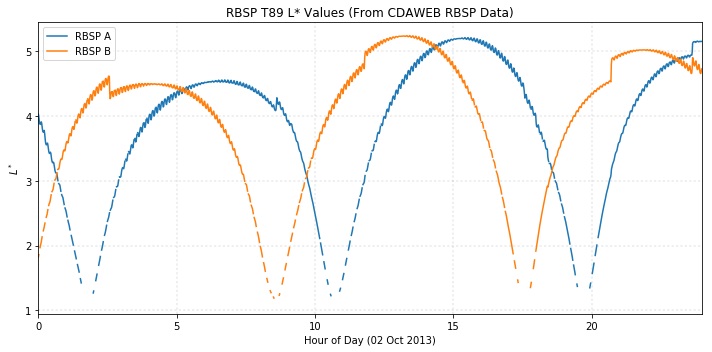

In [35]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

deltaD = EpochA - min(EpochA)
jd = [d.total_seconds() for d in deltaD]
x1 = np.asarray(jd)/60/60


deltaD = EpochB - min(EpochB)
jd = [d.total_seconds() for d in deltaD]
x2 = np.asarray(jd)/60/60



y1 = L89QA
y2 = L89QB

ax.plot(x1, y1, label="RBSP A", lw=1.5)
ax.plot(x2, y2, label="RBSP B", lw=1.5)
# plot_colorline(EpochA, L89QA, K89QA)
ax.set_title("RBSP T89 L* Values (From CDAWEB RBSP Data)")
ax.set_ylabel("$L^*$")
ax.set_xlabel("Hour of Day (02 Oct 2013)")
plt.xlim(np.min(x1), np.max(x2))

plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
plt.tight_layout()
plt.legend()
plt.show()
fig.savefig(pathout+"RBSP_T89_Lstar.pdf")

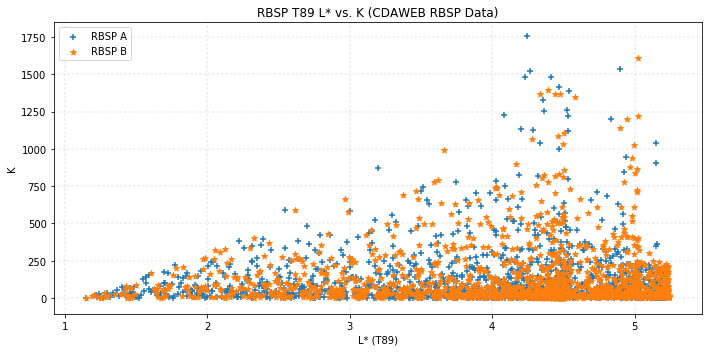

In [34]:
k1 = K89QA
k2 = K89QB

fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(111)

yA = k1
yB = k2

xA = y1
xB = y2

ax.scatter(xA, yA, marker="+", label="RBSP A")
ax.scatter(xB, yB, marker="*", label="RBSP B")
plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')


ax.set_title("RBSP T89 L* vs. K (CDAWEB RBSP Data)")
ax.set_xlabel("L* (T89)")
ax.set_ylabel("K")
fig.tight_layout()
plt.legend()
fig.savefig(pathout+"RBSP_T89_LvK.pdf")


In [27]:
def get_col(x,y,t):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=plt.get_cmap('gist_stern'),
                    norm=colors.LogNorm(1e-0, 1e3))
    lc.set_array(t)
    lc.set_linewidth(3)
    return lc


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as colors
import jdcal
import mx.DateTime as dt

# datetime.datetime.ctime

deltaD = EpochA - min(EpochA)
jd = [d.total_seconds() for d in deltaD]
x = np.asarray(jd)/60.0/60.0
y = np.array(L89QA).flatten()
t = np.array(K89QA).flatten()


xa = x
ya = y
ta = t

lc1 = get_col(xa,ya,ta)
deltaD = EpochB - min(EpochB)

jd = [d.total_seconds() for d in deltaD]
x2 = np.asarray(jd)/60.0/60.0
y2 = np.array(L89QB).flatten()
t2 = np.array(K89QB).flatten()

xa = x2
ya = y2
ta = t2

lc2 = get_col(xa,ya,ta)

/usr/local/lib/python2.7/site-packages/matplotlib/colors.py:925: RuntimeWarning: invalid value encountered in less_equal
  mask = (resdat <= 0)
/usr/local/lib/python2.7/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


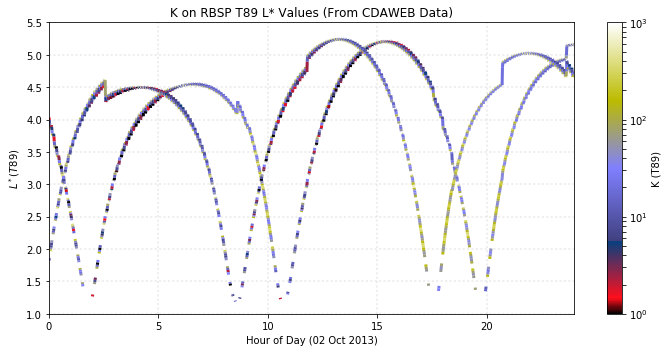

In [29]:
fig2 = plt.figure(figsize=(10,5))
ax = fig2.gca()

ax.add_collection(lc1)
ax.add_collection(lc2)
axcb = fig2.colorbar(lc1)
axcb.set_label('K (T89)')

plt.xlim(np.min(xa), np.max(xa))
plt.ylim(1, 5.5)
ax.set_title("K on RBSP T89 L* Values (From CDAWEB Data)")
ax.set_ylabel("$L^*(T89)$")
ax.set_xlabel("Hour of Day (02 Oct 2013)")
fig2.tight_layout()
plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
plt.show()
fig2.savefig(pathout+"RBSP_T89_Color_Lstar.pdf")

In [30]:
ephemA = pycdf.CDF(path+"rbsp-a_magnetometer_hires-sm_emfisis-l3_20131002_v1.3.4.cdf")
ephemB = pycdf.CDF(path+"rbsp-b_magnetometer_hires-sm_emfisis-l3_20131002_v1.6.1.cdf")

In [31]:
print(ephemB)

Epoch: CDF_TIME_TT2000 [5529600]
MET: CDF_REAL8 [5529600]
Mag: CDF_REAL4 [5529600, 3]
Mag_LABL_1: CDF_CHAR*8 [3] NRV
Magnitude: CDF_REAL4 [5529600]
calState: CDF_BYTE [5529600]
coordinates: CDF_REAL4 [5529600, 3]
coordinates_LABL_1: CDF_CHAR*8 [3] NRV
delta: CDF_REAL4 [5529600]
lambda: CDF_REAL4 [5529600]
magFill: CDF_BYTE [5529600]
magInvalid: CDF_BYTE [5529600]
partition: CDF_BYTE [5529600]
range_flag: CDF_BYTE [5529600]


In [ ]:
pts_EPOCH_a = (ephemA['Epoch'][...])[0::(60*60)].copy()
pts_EPOCH_b = (ephemB['Epoch'][...])[0::(60*60)].copy()

pts_sm_a = (ephemA['coordinates'][...])[0::(60*60)].copy()
pts_sm_b = (ephemB['coordinates'][...])[0::(60*60)].copy()

In [ ]:
pickle.dump(pts_EPOCH_a, open("pts_EPOCH_a.pickle", "wb"))
pickle.dump(pts_EPOCH_b, open("pts_EPOCH_b.pickle", "wb"))
pickle.dump(pts_sm_a, open("pts_sm_a.pickle", "wb"))
pickle.dump(pts_sm_b, open("pts_sm_b.pickle", "wb"))


In [ ]:
print(len(pts_EPOCH_a))

In [ ]:
import ghostpy.algorithms.common as algc
import ghostpy.algorithms.DipoleField as dpf
import ghostpy.Invariants.FieldLine as fl
import ghostpy.Invariants.LShell as ls
import ghostpy.data.DipoleData as dpd
import ghostpy.data.VtkData as vdt

In [ ]:

ptr = pts_sm_a/6371
data = vdt.VtkData(filename="../unit_tests/test_data/lfm_dipole_test_quad.vts", vector="B")

dL = []
dK = []
dB = []
for pt in ptr:
    lsx = ls.LShell(data=data, start_loc=pt)
    dK.append(lsx.k)
    dB.append(lsx.b)
    dL.append(lsx.l_star(res=1000))
    print ("Footprint: {}\nL:{}".format(fp, dL[-1]))



In [ ]:
ptr = pts_sm_b/6371.0

dL2 = []
dK2 = []
dB2 = []
for pt in ptr:
    lsx = ls.LShell(data=data, start_loc=pt)
    dK2.append(lsx.k)
    dB2.append(lsx.b)
    dL2.append(lsx.l_star(res=1000))
    print ("Footprint: {}\nL:{}".format(fp, dL[-1]))



In [ ]:
deltaD = pts_EPOCH_a - min(pts_EPOCH_a)
jd = [d.total_seconds() for d in deltaD]
x = np.asarray(jd)/60.0/60.0
y = np.asarray(dL)
t = np.asarray(dK)
ldA = get_col(x,y,t)


In [ ]:
deltaD = pts_EPOCH_b - min(pts_EPOCH_b)
jd = [d.total_seconds() for d in deltaD]
x = np.asarray(jd)/60.0/60.0
y = np.asarray(dL2)
t = np.asarray(dK2)
ldB = get_col(x,y,t)



In [ ]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(111)



fig.tight_layout()

In [ ]:
print a

In [ ]:
c = a-b

In [ ]:
c

In [ ]:
c.total_seconds()

In [ ]:
help(jdcal)

In [ ]:
RBSPA_dat = pickle.load(open("./RBSP_LFM/RBSPA_LFM_LKB.pickle", "rb"))
RBSPB_dat = pickle.load(open("./RBSP_LFM/RBSPB_LFM_LKB.pickle", "rb"))



In [ ]:
print(len(RBSPA_dat))

In [ ]:
RBaL4 = {}
RBaL = {}
RBaK = {}
RBbL4 = {}
RBbL = {}
RBbK = {}
for rank in RBSPA_dat:
    for key in rank:
        K = rank[key][2]
        if K is None:
            K = np.NaN

        RBaL4[key] = rank[key][0]
        RBaL[key] = rank[key][1]
        RBaK[key] = K
        
for rank in RBSPB_dat:
    for key in rank:
        K = rank[key][2]
        if K is None:
            K = np.NaN
        RBbL4[key] = rank[key][0]
        RBbL[key] = rank[key][1]
        RBbK[key] = K
        


In [ ]:

Xa = []
Ya = []
lkeys = sorted(RBaL.keys())

for key in lkeys:
    Xa.append(key)
    Ya.append(RBaL[key])
    
Xb = []
Yb = []
lkeys = sorted(RBbL.keys())

for key in lkeys:
    Xb.append(key)
    Yb.append(RBbL[key])

figL = plt.figure(figsize=[10,5])
axL = figL.add_subplot(111)
axL.plot(Xa, Ya, label="RBSP A", lw=1.5)
axL.plot(Xb, Yb, label="RBSP B", lw=1.5)
axL.set_title("RBSP LFM L* Values (From CDAWEB RBSP Data)")


plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')

